In [13]:
# !git clone https://github.com/Jsrsky/machine_unlearning_experiments
# %cd machine_unlearning_experiments/experiments/cifar10/fisher

## Dependecies

In [14]:
from pathlib import Path
import sys
import copy
from torchvision import datasets
from tqdm.notebook import tqdm

## Utils 

In [15]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [16]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.resnet50 import load_model_resnet50, init_model_resnet50

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import iterative_fisher_unlearn, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [17]:
BATCH_SIZE = 256
MINI_BATCH_SIZE = 8192

SIGMA = 0.1

EPS = 1e-6
MAX_NORM = 1

# CALL FISHER

### Files

In [18]:
model_file = project_root / 'experiments/cifar10/naive/ResNet50_CIFAR10_model.pth'
samples_to_unlearn_file = project_root / 'experiments/cifar10/naive/cifar10_samples_to_unlearn_30per.json'
remaining_dataset_file = project_root / 'experiments/cifar10/naive/updated_cifar10_data_splits.json'

### Init models

In [19]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_resnet50(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])
model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...
Done initializing model.
Model ID: 135024508964288, Optimizer ID: 135024508963664, Criterion ID: 135024508966640
Done loading model.


## Init data

In [20]:
train_dataset = datasets.CIFAR10(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_root, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
unlearn_indices, _unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

In [22]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset), 
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### FIM

In [23]:
import math
import json
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset

from utils.utils import DEVICE

def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ_rem = ∇L(θ, D') over the given dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    
    grad_dict = {}
    total_samples = 0

    model.train()
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in grad_dict:
                    grad_dict[name] = param.grad.detach().clone() * current_batch
                else:
                    grad_dict[name] += param.grad.detach() * current_batch

    # Average gradients over the entire subset
    for name in grad_dict:
        grad_dict[name] /= total_samples

    return grad_dict

def compute_fisher_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute a diagonal approximation of the Fisher Information Matrix F over the given dataset_subset.
    It averages the squared gradients.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)
    fisher_diag = {}
    total_samples = 0

    model.eval()
    for inputs, targets in tqdm(dataloader, desc="Computing Fisher"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        current_batch = inputs.size(0)
        total_samples += current_batch
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name not in fisher_diag:
                    fisher_diag[name] = (param.grad.detach() ** 2) * current_batch
                else:
                    fisher_diag[name] += (param.grad.detach() ** 2) * current_batch

    for name in fisher_diag:
        fisher_diag[name] /= total_samples

    return fisher_diag
    # for name in fisher_diag:
    #     fisher_diag[name] /= total_samples
    # fisher_diag['_total_samples'] = total_samples

    return fisher_diag

def remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, batch_size):
    dataloader = DataLoader(dataset_removed, batch_size=batch_size, shuffle=False)
    total_removed_samples = 0

    model.eval()
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        batch_samples = inputs.size(0)
        total_removed_samples += batch_samples
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher_diag[name] -= (param.grad.detach() ** 2) * batch_samples

    total_samples_remaining = fisher_diag['_total_samples'] - total_removed_samples
    for name in fisher_diag:
        if name != '_total_samples':
            fisher_diag[name] = torch.clamp(fisher_diag[name], min=1e-8)
            fisher_diag[name] /= total_samples_remaining
    fisher_diag['_total_samples'] = total_samples_remaining

    return fisher_diag

def iterative_fisher_unlearn(model, criterion, full_dataset, removal_indices, sigma, deletion_batch_size, compute_batch_size, eps, max_norm):
    """
    Implements the iterative Fisher unlearning procedure following theory:
    
    Inputs:
      - model: a pretrained PyTorch model (trained on full dataset D).
      - criterion: loss function (e.g., CrossEntropyLoss).
      - full_dataset: the full training dataset D (e.g., MNIST training set).
      - removal_indices: list of indices (from the JSON file) to be deleted (Dₘ). E.g., 6000 samples.
      - sigma: noise parameter σ.
      - deletion_batch_size: desired mini-batch size for deletion (m′). E.g., 1000.
      - compute_batch_size: batch size used when computing gradients/Fisher (BATCH_SIZE).
      - eps: for numerical stability
    
    Procedure:
      1. Let current_indices = set(range(len(full_dataset))).
      2. Partition removal_indices into mini-batches of size deletion_batch_size.
      3. For each mini-batch, update current_indices by removing those indices.
      4. Create a Subset from full_dataset using current_indices (this is D').
      5. Compute Δ_rem and diagonal Fisher F on D' and update model:
             θ ← θ − F⁻¹ Δ_rem + σ · F^(–1/4) · ε.
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches, where s = m /m'
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size] for i in range(num_batches)]
    print(f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples).")

    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # fisher_diag = compute_fisher_on_subset(model, criterion, full_dataset, compute_batch_size)
    # NEWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW
    # Iterate over each deletion mini-batch
    for i, batch in enumerate(tqdm(partitioned_removals, desc="Fisher step over mini-batches")):
        # Remove the current batch of indices from current_indices
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        # Create a Subset corresponding to the updated dataset D' = D \ (deleted so far)
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}")
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWW
        # dataset_removed = Subset(full_dataset, batch)
        # fisher_diag = remove_from_fisher_incrementally(fisher_diag, model, criterion, dataset_removed, compute_batch_size)
        # NEWWWWWWWWWWWWWWWWWWWWWWWWWWW
        # Compute the average gradient and diagonal Fisher on D'
        grad_dict = compute_gradient_on_subset(model, criterion, dataset_remaining, compute_batch_size)
        fisher_diag = compute_fisher_on_subset(model, criterion, dataset_remaining, compute_batch_size)
        # Update model parameters using the Newton correction and noise injection
        with torch.no_grad():
            for name in grad_dict:
                grad = grad_dict[name]
                norm = grad.norm(2).item()
                grad_min = grad.min().item()
                grad_max = grad.max().item()
                grad_mean = grad.mean().item()
                grad_std = grad.std().item()
                print(f"[Raw] Param {name}: norm = {norm:.4e}, min = {grad_min:.4e}, max = {grad_max:.4e}, mean = {grad_mean:.4e}, std = {grad_std:.4e}")
            
            # First, compute and clip gradients, and monitor norms
            total_grad_norm_before = 0.0
            total_grad_norm_after = 0.0
            for name in grad_dict:
                norm_before = grad_dict[name].norm(2)
                total_grad_norm_before += norm_before.item()
                if norm_before > max_norm:
                    grad_dict[name] = grad_dict[name] * (max_norm / norm_before)
                norm_after = grad_dict[name].norm(2)
                total_grad_norm_after += norm_after.item()
            
            print(f"Iteration {i+1}: Total gradient norm before clipping = {total_grad_norm_before:.4f}")
            print(f"Iteration {i+1}: Total gradient norm after clipping  = {total_grad_norm_after:.4f}")
            
            # Now, update model parameters using the clipped gradients and monitor the Newton update norm
            total_update_norm = 0.0
            for name, param in model.named_parameters():
                if param.requires_grad:
                    inv_fisher = (fisher_diag[name] + eps).pow(-1)
                    newton_update = inv_fisher * grad_dict[name]
                    total_update_norm += newton_update.norm(2).item()
                    param.data = param.data - newton_update

                    inv_fisher_quarter = (fisher_diag[name] + eps).pow(-0.25)
                    noise = torch.randn_like(param.data)
                    param.data = param.data + sigma * inv_fisher_quarter * noise

            print(f"Iteration {i+1}: Total Newton update norm = {total_update_norm:.4f}")
        print(f"Iteration {i+1}/{num_batches} update completed.")
        
    return model

### Unlearn

In [24]:
import time
start_time = time.perf_counter()

unlearned_model = iterative_fisher_unlearn(
    model_to_unlearn,
    criterion,
    train_dataset,
    unlearn_indices,
    SIGMA,
    deletion_batch_size=MINI_BATCH_SIZE,
    compute_batch_size=BATCH_SIZE,
    eps=EPS,
    max_norm=MAX_NORM,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Total deletion samples: 15000; partitioned into 2 mini-batches (each up to 8192 samples).


Fisher step over mini-batches:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration 1/2: Remaining dataset size = 41808



Computing gradients: 100%|██████████| 164/164 [04:05<00:00,  1.50s/it]

Fisher step over mini-batches:  50%|█████     | 1/2 [07:58<07:58, 478.64s/it]

[Raw] Param module.conv1.weight: norm = 3.3649e-01, min = -1.6258e-02, max = 2.0496e-02, mean = 3.9631e-04, std = 3.4467e-03
[Raw] Param module.bn1.weight: norm = 2.9718e-03, min = -9.2374e-04, max = 1.5231e-03, mean = 2.5953e-05, std = 3.7349e-04
[Raw] Param module.bn1.bias: norm = 8.9561e-04, min = -5.2793e-04, max = 2.3263e-04, mean = -1.2180e-05, std = 1.1217e-04
[Raw] Param module.layer1.0.conv1.weight: norm = 2.7794e-02, min = -5.7053e-03, max = 7.8347e-03, mean = 1.0442e-05, std = 4.3420e-04
[Raw] Param module.layer1.0.bn1.weight: norm = 1.3053e-03, min = -2.9463e-04, max = 6.4561e-04, mean = 1.0836e-06, std = 1.6445e-04
[Raw] Param module.layer1.0.bn1.bias: norm = 8.8395e-04, min = -2.2483e-04, max = 2.5282e-04, mean = 3.8114e-06, std = 1.1130e-04
[Raw] Param module.layer1.0.conv2.weight: norm = 2.7328e-02, min = -2.0067e-03, max = 1.5860e-03, mean = -4.7429e-06, std = 1.4226e-04
[Raw] Param module.layer1.0.bn2.weight: norm = 2.4225e-03, min = -6.1214e-04, max = 1.7621e-03, mea


Computing gradients: 100%|██████████| 137/137 [03:25<00:00,  1.50s/it]

Fisher step over mini-batches: 100%|██████████| 2/2 [14:37<00:00, 438.81s/it]

[Raw] Param module.conv1.weight: norm = 2.5289e+04, min = -9.0577e+02, max = 1.8529e+03, mean = 4.7890e+01, std = 2.5631e+02
[Raw] Param module.bn1.weight: norm = 1.3843e+04, min = -5.3752e+03, max = 2.8650e+03, mean = -5.2014e+01, std = 1.7433e+03
[Raw] Param module.bn1.bias: norm = 1.1266e+04, min = -4.1234e+03, max = 7.9056e+03, mean = 2.1492e+02, std = 1.4027e+03
[Raw] Param module.layer1.0.conv1.weight: norm = 2.6932e+04, min = -6.3971e+03, max = 3.4561e+03, mean = -1.8218e+01, std = 4.2047e+02
[Raw] Param module.layer1.0.bn1.weight: norm = 6.1456e+03, min = -2.8699e+03, max = 2.4057e+03, mean = 1.1572e+02, std = 7.6544e+02
[Raw] Param module.layer1.0.bn1.bias: norm = 3.2855e+03, min = -9.9124e+02, max = 1.6220e+03, mean = -7.8560e+01, std = 4.0629e+02
[Raw] Param module.layer1.0.conv2.weight: norm = 2.2328e+03, min = -1.3344e+02, max = 1.3329e+02, mean = -9.4904e-02, std = 1.1629e+01
[Raw] Param module.layer1.0.bn2.weight: norm = 3.7155e+03, min = -9.3970e+02, max = 1.9572e+03, m

In [25]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

### Test and metrics

In [26]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [27]:
model, *_ = init_model_resnet50()
import torch.nn as nn
model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 135024507394928, Optimizer ID: 135024508092624, Criterion ID: 135024508097232
Loading and testing model: fisher_ResNet50_CIFAR10


Evaluating model: fisher_ResNet50_CIFAR10_model.pth: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]

Predictions and labels saved to fisher_ResNet50_CIFAR10_predictions.json


Metrics for fisher_ResNet50_CIFAR10:
  - Test Accuracy: 0.1000
  - Precision: 0.0100
  - Recall: 0.1000
  - F1 Score: 0.0182


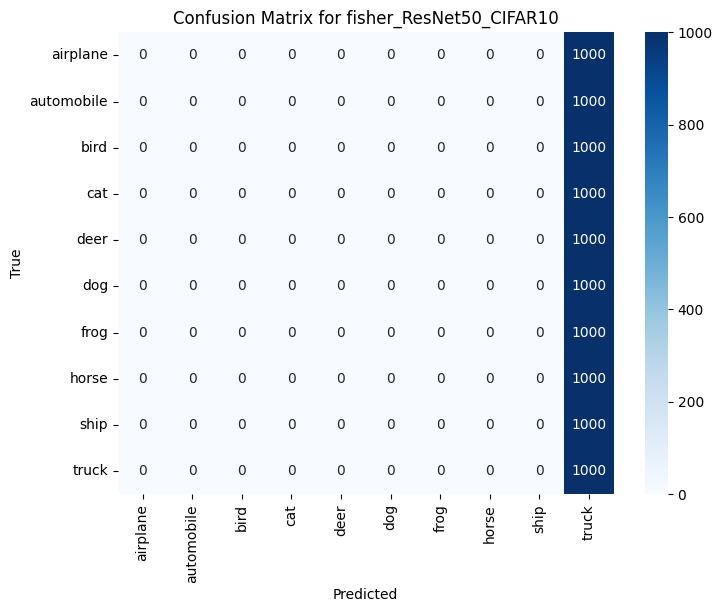

In [28]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
#classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_metrics(predictions_path, classes, model_to_unlearn_name)